In [1]:
#indir = "/home/isshamie/data/Projects/Mito_Trace/output/annotation_clones/data/cd34norm/MTblacklist/DE_large"
indir = "/home/isshamie/data/Projects/Mito_Trace/output/pipeline/cd34norm/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/vireo/nclones20/annotation_clones/DE_large/minPct_0.01__logThresh_0"

se_indir = "/home/isshamie/data/Projects/Mito_Trace/output/pipeline/cd34norm/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/vireo/nclones20/annotation_clones/DE_large"
n_donors = 4
cdf_thresh = 0.3

n_top_genes = 5
n_top_clones = 3
utils_script <- "/home/isshamie/data/Projects/Mito_Trace/R_scripts/seurat_utils.R"


In [2]:
source(utils_script)

Attaching SeuratObject



In [3]:
outdir <- paste0(indir, "/", "cdf_thresh__", (cdf_thresh))
dir.create(outdir)

Warning message in dir.create(outdir):
“'/home/isshamie/data/Projects/Mito_Trace/output/pipeline/cd34norm/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/vireo/nclones20/annotation_clones/DE_large/minPct_0.01__logThresh_0/cdf_thresh__0.3' already exists”


In [4]:
library(Seurat)
library(Signac)
library(ggplot2)
library(patchwork)
set.seed(1234)
library(magrittr)
library(cowplot)
library(metap)
library(dplyr)
library(future)
library("ComplexHeatmap")
library(motifmatchr)
library(JASPAR2020)
library(TFBSTools)
library(BSgenome.Hsapiens.UCSC.hg38)



Attaching package: ‘cowplot’


The following object is masked from ‘package:patchwork’:

    align_plots



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: grid

ComplexHeatmap version 2.10.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))




Loading required package: B

## Import seurat object

In [5]:
se <- readRDS(file.path(se_indir, "se.clonesfilt.rds"))
init.large.clones <- read.csv(file.path(se_indir, "large_clones.csv"))
large.clones <- init.large.clones %>% filter(cdf.norm<cdf_thresh)

large.clones <- check.if.one.clone(large.clones, init.large.clones, n_top_clones)
large.clones

[1] 2
[1] "i 1 donor 0"
[1] "only 1 clone. Using top 3 clones"
[1] "i 2 donor 3"


X,donor,lineage,norm.total,total,name,cdf.norm,cdf,index
<int>,<int>,<int>,<dbl>,<int>,<chr>,<dbl>,<int>,<int>
9,3,2,0.2285052,144,3_2,0.1142526,144,1
10,3,13,0.1893704,151,3_13,0.2089378,295,2
11,3,4,0.1398944,100,3_4,0.2788850,395,3
1,0,3,0.2672711,253,0_3,0.1336355,253,1
2,0,6,0.2625955,239,0_6,0.2649333,492,2
3,0,16,0.2608498,223,0_16,0.3953582,715,3


In [6]:
se <- subset(se, subset= name %in% factor(large.clones$name))

In [7]:
Idents(se) <- "name"

Saving 6.67 x 6.67 in image



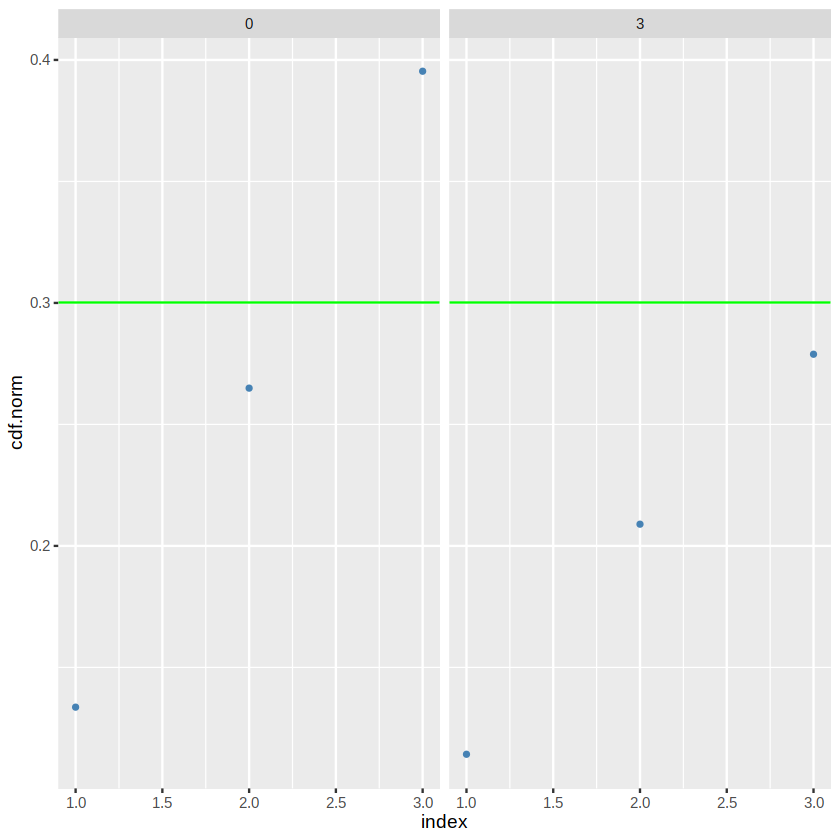

In [8]:
p <- ggplot(data = large.clones, aes(index, cdf.norm)) +
  geom_point(color = "steelblue", size = 1) +
  facet_wrap(~ donor) 

p <- p + geom_hline(yintercept=cdf_thresh, color='green') 
p
ggsave(file.path(outdir, "large.clones.cdf.png"))



In [9]:
## Get motif names

# DefaultAssay(se) <- "chromvar"
# chrom.var.names <- GetAssayData(se)
# DefaultAssay(se) <- "ATAC"
# motifs <- Motifs(se)
# #Motifs(se)@motif.names

# head(chrom.var.names)
# row.names(chrom.var.names) <- sapply(row.names(chrom.var.names), function(x) {Motifs(se)@motif.names[[x]]})
# head(chrom.var.names)




## TF DE

## Summarize results

In [10]:
# all.names.sig <- c()
# DefaultAssay(se) <- "chromvarnames"
# for (d in 0:(n_donors-1)){
#     print('donor')
#     print(d)
#     curr.indir <- file.path(indir, paste0("donor", d, "_TF"))
#     #curr.outdir <- file.path(outdir, paste0("donor", d, "_TF"))
#     #dir.create(curr.outdir)
#     donor.large.clones <- large.clones %>% filter(donor==d)
#     clones.filt.ids <- sort(donor.large.clones$lineage)
#     se.filt <- subset(se, subset = (donor==d) & (lineage %in% donor.large.clones$lineage))
#     if (length(clones.filt.ids) < 2){
#         print("0 or 1 clone found. not running")
#         next
#     }
#     pairs = combn(clones.filt.ids,2)
#     names.sig <- c()

#     for (i in 1:dim(pairs)[2]){
#         print(pairs[,i])
#         print(paste("comparison #", i))
#         a = pairs[1,i]
#         b = pairs[2,i]
#         curr.tf.da <- read.csv(file.path(curr.indir, 
#                                          paste0("clones_",a,"__", b,".DE.TF.csv"))) %>% 
#                       arrange(p_val)
#         row.names(curr.tf.da) <- curr.tf.da$X  #sapply(curr.tf.da$X, function(m) {motifs@motif.names[[m]]})
#         names.sig <- c(names.sig, head(row.names(curr.tf.da), n_top_genes))
#         all.names.sig <- c(all.names.sig, head(row.names(curr.tf.da), n_top_genes))
#         }
#     names.sig <- unique(names.sig)
    
#     gally <- GGally::ggpairs(curr.tf.da[,c("p_val", "p_val_adj")], aes(alpha = 0.4))
# }


In [24]:
all.names.sig <- c()
DefaultAssay(se) <- "chromvarnames"
for (d in 0:(n_donors-1)){
    print('donor')
    print(d)
    curr.indir <- file.path(indir, paste0("donor", d, "_TF"))
    curr.outdir <- file.path(outdir, paste0("donor", d, "_TF"))
    dir.create(curr.outdir)
    donor.large.clones <- large.clones %>% filter(donor==d)
    if (dim(donor.large.clones)[1] < 2){
        print('no donor')
        next
    }
    clones.filt.ids <- sort(donor.large.clones$lineage)
    se.filt <- subset(se, subset = (donor==d) & (lineage %in% donor.large.clones$lineage))
    if (length(clones.filt.ids) < 2){
        print("0 or 1 clone found. not running")
        next
    }
    pairs = combn(clones.filt.ids,2)
    names.sig <- c()

    for (i in 1:dim(pairs)[2]){
        print(pairs[,i])
        print(paste("comparison #", i))
        a = pairs[1,i]
        b = pairs[2,i]
        curr.tf.da <- read.csv(file.path(curr.indir, 
                                         paste0("clones_",a,"__", b,".DE.TF.csv"))) %>% 
                      arrange(p_val)
        print(head(curr.tf.da))
        row.names(curr.tf.da) <- curr.tf.da$X  #sapply(curr.tf.da$X, function(m) {motifs@motif.names[[m]]})
        #curr.tf.da
        names.sig <- c(names.sig, head(row.names(curr.tf.da), n_top_genes))
        all.names.sig <- c(all.names.sig, head(row.names(curr.tf.da), n_top_genes))
        gally <- GGally::ggpairs(curr.tf.da[,c("p_val", "p_val_adj", "avg_diff")], aes(alpha = 0.4))
        ggsave(plot=gally, 
                   file=file.path(curr.outdir, paste0("clones_",a,"__", b,".DE.TF.pvalHist.top.png")))
        DefaultAssay(se.filt) <- "ATAC"
        raw.ids <- names(Motifs(se.filt)@motif.names)
        rownames(curr.tf.da) <- sapply((curr.tf.da$X), function(x){raw.ids[match(x, Motifs(se.filt)@motif.names)]})
        m <- MotifPlot(
          object = se.filt,
          motifs = head(rownames(curr.tf.da)),
          assay = 'ATAC'
        )
        ggsave(plot=m, 
                   file=file.path(curr.outdir, paste0("clones_",a,"__", b,".DE.TF.motif.top.png")))


        }
    DefaultAssay(se.filt) <- "chromvarnames"
    names.sig <- unique(names.sig)
    

    feat <- FeaturePlot(se.filt,  features=names.sig)

    vln <- VlnPlot(se.filt,  features=names.sig, pt.size = 0)

    dot <- DotPlot(se.filt, features = names.sig) + RotatedAxis()

    # split by a vector
    pdf((file.path(curr.outdir, "heatmap.top.pdf")), width=8,height=8)
    
    heat <- ComplexHeatmap::Heatmap(GetAssayData(se.filt)[names.sig,], 
            name = paste0("donor",d),
            column_split = se.filt[[]]["lineage"],
            show_column_names = FALSE, use_raster=TRUE
           )
    ComplexHeatmap::draw(heat)
    dev.off()
    
    ggsave(plot=feat, 
           file=file.path(curr.outdir, ("embedFeat.top.png")))
    ggsave(plot=dot, 
           file=file.path(curr.outdir, ("dot.top.png")))
    ggsave(plot=vln, 
           file=file.path(curr.outdir, ("violin.top.png")))
    }
all.names.sig <- unique(all.names.sig)

[1] "donor"
[1] 0


Warning message in dir.create(curr.outdir):
“'/home/isshamie/data/Projects/Mito_Trace/output/pipeline/cd34norm/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/vireo/nclones20/annotation_clones/DE_large/minPct_0.01__logThresh_0/cdf_thresh__0.3/donor0_TF' already exists”


[1] 3 6
[1] "comparison # 1"
       X       p_val   avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
1    EN1 0.001614396 -0.2527346 0.427 0.552         1    0.9590511
2   NRF1 0.003488216 -0.2307171 0.372 0.510         1    0.9590511
3  PITX2 0.005549975 -0.2498954 0.447 0.565         1    0.9590511
4 ZNF136 0.008606004  0.2111347 0.561 0.485         1    0.9590511
5   LBX2 0.009725295 -0.2127362 0.451 0.556         1    0.9590511
6  SOX18 0.013369175 -0.1763218 0.447 0.565         1    0.9590511


Saving 6.67 x 6.67 in image

Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Saving 6.67 x 6.67 in image



[1]  3 16
[1] "comparison # 2"
       X      p_val   avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
1  SOX10 0.01016403  0.2022925 0.569 0.471         1    0.9833399
2   NRF1 0.01258118 -0.1596748 0.372 0.489         1    0.9833399
3 PLAGL2 0.01294084 -0.1887889 0.447 0.578         1    0.9833399
4 ZNF274 0.01308723 -0.2230894 0.415 0.507         1    0.9833399
5    MAX 0.01316097 -0.2044427 0.490 0.596         1    0.9833399
6  MEF2C 0.01592611  0.2019128 0.486 0.426         1    0.9833399


Saving 6.67 x 6.67 in image

Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Saving 6.67 x 6.67 in image



[1]  6 16
[1] "comparison # 3"
       X       p_val  avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
1    ERG 0.002193156 0.2494597 0.544 0.430         1    0.7703088
2  FOXC1 0.010055740 0.2086031 0.590 0.457         1    0.7703088
3  SOX18 0.010096347 0.2154267 0.565 0.439         1    0.7703088
4 ZNF682 0.011962878 0.1961677 0.573 0.466         1    0.7703088
5  STAT1 0.013224236 0.2328577 0.481 0.395         1    0.7703088
6  GATA6 0.013224236 0.4470517 0.406 0.287         1    0.7703088


Saving 6.67 x 6.67 in image

Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Saving 6.67 x 6.67 in image

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "donor"
[1] 1


Warning message in dir.create(curr.outdir):
“'/home/isshamie/data/Projects/Mito_Trace/output/pipeline/cd34norm/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/vireo/nclones20/annotation_clones/DE_large/minPct_0.01__logThresh_0/cdf_thresh__0.3/donor1_TF' already exists”


[1] "no donor"
[1] "donor"
[1] 2
[1] "no donor"
[1] "donor"
[1] 3
[1] 2 4
[1] "comparison # 1"
       X       p_val   avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
1  TEAD2 0.001011081  0.3848167 0.542  0.39 0.6400140    0.2695109
2 BARHL2 0.001220946  0.3724922 0.556  0.42 0.7728590    0.2695109
3    SP3 0.001277303 -0.2893418 0.319  0.42 0.8085326    0.2695109
4  KLF11 0.003353539 -0.2564694 0.306  0.47 1.0000000    0.4136472
5    SP8 0.004072862 -0.3114064 0.347  0.46 1.0000000    0.4136472
6   KLF2 0.004316983 -0.2906920 0.312  0.42 1.0000000    0.4136472


Saving 6.67 x 6.67 in image

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Saving 6.67 x 6.67 in image



[1]  2 13
[1] "comparison # 2"
             X        p_val   avg_diff pct.1 pct.2  p_val_adj p_val_adj_BH
1 CEBPG(var.2) 1.602313e-05  0.8547609 0.646 0.477 0.01014264  0.005818684
2         ATF4 2.112210e-05  0.6569591 0.632 0.411 0.01337029  0.005818684
3        CEBPA 2.757670e-05  0.8278851 0.701 0.490 0.01745605  0.005818684
4        CEBPD 2.056529e-04  0.8190298 0.674 0.503 0.13017827  0.032544567
5         ETV6 1.041304e-03 -0.4230577 0.382 0.517 0.65914562  0.109290804
6        FOSL2 1.203037e-03 -0.7465313 0.319 0.483 0.76152254  0.109290804


Saving 6.67 x 6.67 in image

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Saving 6.67 x 6.67 in image



[1]  4 13
[1] "comparison # 3"
               X       p_val   avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
1           ATF4 0.001279800  0.5903657  0.56 0.411 0.8101133    0.5002807
2          VENTX 0.001995941  0.3834299  0.57 0.358 1.0000000    0.5002807
3           HIC2 0.002370999  0.3617559  0.61 0.464 1.0000000    0.5002807
4 CREB3L4(var.2) 0.007271011 -0.3870667  0.45 0.523 1.0000000    0.8456410
5           CREM 0.008339696 -0.3129998  0.36 0.450 1.0000000    0.8456410
6   CEBPG(var.2) 0.008878734  0.5655002  0.56 0.477 1.0000000    0.8456410


Saving 6.67 x 6.67 in image

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Saving 6.67 x 6.67 in image

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



## Dotplot for all donors

In [25]:
pdf(file = file.path(outdir, "./dotplot.allDonors.top.pdf"), width = 8, height = 8)
dot <- DotPlot(se, features = all.names.sig, group.by="donor") + RotatedAxis()
dot
dev.off()

png 
  2

In [26]:
pdf(file = file.path(outdir, "./dotplot.allDonors.clones.top.pdf"), width = 8, height = 8)
dot <- DotPlot(se, features = all.names.sig, group.by="name", cluster.idents=T) + RotatedAxis()
dot
dev.off()

png 
  2

## Heatmap for all donors

In [27]:
pdf((file.path(outdir, "heatmap.allDonors.top.pdf")), width=8,height=8)
heat <- ComplexHeatmap::Heatmap(GetAssayData(se)[names.sig,], 
        top_annotation = HeatmapAnnotation(donor=as.character(se$donor)),
        show_column_names = FALSE, 
        column_split = se[["name"]],
       )

ComplexHeatmap::draw(heat)
dev.off()

png 
  2

In [28]:
# pdf((file.path(outdir, "heatmap.allDonors.anno.top.pdf")), width=8,height=8)
# heat <- ComplexHeatmap::Heatmap(GetAssayData(se)[all.names.sig,], 
#         top_annotation = HeatmapAnnotation(donor=as.character(se$donor), clone=as.character(se$lineage), 
#                                            depth=anno_barplot(log10(se$peak_region_fragments))),
#         show_column_names = FALSE
#        )

# ComplexHeatmap::draw(heat)
# dev.off()

In [29]:
pdf((file.path(outdir, "heatmap.allDonors.split.top.pdf")), width=8,height=8)
heat <- ComplexHeatmap::Heatmap(GetAssayData(se)[all.names.sig,], 
        top_annotation = HeatmapAnnotation(donor=as.character(se$donor)),
        show_column_names = FALSE, 
        column_split = se[["name"]],
       )

ComplexHeatmap::draw(heat)
dev.off()

png 
  2